# MIADS Quicken Loans Data Challenge 
## Liu Jason Tan
## Master in Applied Data Science, School of Information

### Initial Data Cleaning

In [1]:
# imports
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score
import matplotlib.pyplot as plt
import statistics

# read csv file
data=pd.read_csv('QL_MIDAS_DC_3-29-21.csv')

# convert strings to datetime object where necessary
data['LeadDate']=pd.to_datetime(data['LeadDateID'], format='%Y%m%d')
data['CallStartDateTime']=pd.to_datetime(data['CallStartDateTime'], format='%Y-%m-%d %H:%M:%S')

# drop the old data column
data.drop(columns='LeadDateID', inplace=True)

# dictionary for appication/opt-out
d1={10:1,9560:0,9729:0}

# map dictionary to LeadStatus
data['Success']=data['LeadStatus'].map(d1)
data.drop(columns=['LeadStatus'], inplace=True)

# only keep calls with duration greater than 0
data=data[data['CallDurationSeconds']>0]

# Groupby LeadID and CallID
data_unique=data.groupby(['LeadIDHashed','CallID']).first()

data_unique

LeadLoanAmountDollars  \
LeadIDHashed                                       CallID                             
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E4191... 971463849               351000.0   
                                                   971484057               351000.0   
                                                   971586179               351000.0   
                                                   971650841               351000.0   
                                                   972283589               351000.0   
...                                                                             ...   
0xFFFF45F78C193AC528729A0905769C3A3426A529E1D15... 986584642                    0.0   
0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE7... 914082936               281659.0   
                                                   914406541               281659.0   
                                                   914491260               281659.0   
                                                   914580581               281659.0   

                                                              LeadStateID  \
LeadIDHashed                                       CallID                   
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E4191... 971463849        74483   
                                                   971484057        74483   
                                                   971586179        74483   
                                                   971650841        74483   
                                                   972283589        74483   
...                                                                   ...   
0xFFFF45F78C193AC528729A0905769C3A3426A529E1D15... 986584642        74479   
0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE7... 914082936        74442   
                                                   914406541        74442   
                                                   914491260        74442   
                                                   914580581        74442   

                                                              LeadScore  \
LeadIDHashed                                       CallID                 
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E4191... 971463849     0.0305   
                                                   971484057     0.0305   
                                                   971586179     0.0305   
                                                   971650841     0.0305   
                                                   972283589     0.0305   
...                                                                 ...   
0xFFFF45F78C193AC528729A0905769C3A3426A529E1D15... 986584642     0.0039   
0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE7... 914082936     0.1572   
                                                   914406541     0.1572   
                                                   914491260     0.1572   
                                                   914580581     0.1572   

                                                              CallDirectionID  \
LeadIDHashed                                       CallID                       
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E4191... 971463849                1   
                                                   971484057                1   
                                                   971586179                1   
                                                   971650841                1   
                                                   972283589                1   
...                                                                       ...   
0xFFFF45F78C193AC528729A0905769C3A3426A529E1D15... 986584642                1   
0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE7... 914082936                1   
                                                   914406541                2   
                                                   914491260 

### Create another dataframe that stores the number of calls per lead

In [2]:
# get LeadIDHashed
data_counts=pd.DataFrame(list(data_unique.index.get_level_values(0)))
data_counts.columns=['LeadIDHashed']

# add count column
data_counts['CallCount']=1

# groupby to get count
data_counts=data_counts.groupby(['LeadIDHashed']).count()

# create a list of call sequence
li=[]
for i in data_counts['CallCount']:
    for j in range(1,i+1):
        li.append(j)
        
data_counts

,CallCount
LeadIDHashed,
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E419143AD57C777A5651A0A1,29
0x00016BECFE53FE7599F073A51C828407A4CDAB675005FA47B78058C1DE140276,5
0x00020EFBF145E1DD9D8ED6223E1CB863A43D0BBAED36FF15A11D56D00B70B85E,5
0x000286332CC5CE2C9A8FF20A0DCD8417D61D399D10381B78621FCE908B72998C,4
0x000292E71069EDFE7E2BA6EB6D933CB0C1E3CEC1E24F61A7807AD64C34687492,7
...,...
0xFFFE9AC7470698D24CC5BF312BE6EAE70D434C45B8A1645A32C97BB33716ABF1,5
0xFFFF18486772877CFAEFBABF3C497BCE50201F9DB7849F0B735F58083E9D6BA4,3
0xFFFF1A5E7B37EDD3EE7A228D76D75FDB53B9D0FDA49CA75DABAA303CFEEA55BA,20


### Combine the two dataframes

In [3]:
# add call sequence 
data_unique['CallSequence']=li

# reset the index
data_unique=data_unique.reset_index()

# merge dataframes
combined=data_unique.merge(data_counts, how='inner', left_on=['LeadIDHashed'], right_index=True)

# groupby to go back to original index
combined=combined.groupby(['LeadIDHashed','CallID']).first()

# get cumulative duration 
duration=combined['CallDurationSeconds'].reset_index()
duration=duration.groupby(['LeadIDHashed']).cumsum()
cumsum=list(duration['CallDurationSeconds'])
combined['CumulativeCallTime']=cumsum

# drop null rows and erroreous states
combined=combined[~combined['LeadScore'].isnull()]
combined=combined[combined['LeadStateID']!=-1]

combined

LeadLoanAmountDollars  \
LeadIDHashed                                       CallID                             
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E4191... 971463849               351000.0   
                                                   971484057               351000.0   
                                                   971586179               351000.0   
                                                   971650841               351000.0   
                                                   972283589               351000.0   
...                                                                             ...   
0xFFFF45F78C193AC528729A0905769C3A3426A529E1D15... 986584642                    0.0   
0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE7... 914082936               281659.0   
                                                   914406541               281659.0   
                                                   914491260               281659.0   
                                                   914580581               281659.0   

                                                              LeadStateID  \
LeadIDHashed                                       CallID                   
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E4191... 971463849        74483   
                                                   971484057        74483   
                                                   971586179        74483   
                                                   971650841        74483   
                                                   972283589        74483   
...                                                                   ...   
0xFFFF45F78C193AC528729A0905769C3A3426A529E1D15... 986584642        74479   
0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE7... 914082936        74442   
                                                   914406541        74442   
                                                   914491260        74442   
                                                   914580581        74442   

                                                              LeadScore  \
LeadIDHashed                                       CallID                 
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E4191... 971463849     0.0305   
                                                   971484057     0.0305   
                                                   971586179     0.0305   
                                                   971650841     0.0305   
                                                   972283589     0.0305   
...                                                                 ...   
0xFFFF45F78C193AC528729A0905769C3A3426A529E1D15... 986584642     0.0039   
0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE7... 914082936     0.1572   
                                                   914406541     0.1572   
                                                   914491260     0.1572   
                                                   914580581     0.1572   

                                                              CallDirectionID  \
LeadIDHashed                                       CallID                       
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E4191... 971463849                1   
                                                   971484057                1   
                                                   971586179                1   
                                                   971650841                1   
                                                   972283589                1   
...                                                                       ...   
0xFFFF45F78C193AC528729A0905769C3A3426A529E1D15... 986584642                1   
0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE7... 914082936                1   
                                                   914406541                2   
                                                   914491260 

### Create percentage data for call direction and transfer flag

In [4]:
# get call direction
direction=combined.loc[:,['CallDirectionID','CallCount']]

# change values to 0 and 1
direction['CallDirectionID']=direction['CallDirectionID']-1

# reset index and groupby to get total inbound amount
direction=direction.reset_index()
direction=direction.groupby(['LeadIDHashed','CallCount']).sum()
direction.drop(columns=['CallID'], inplace=True)
direction=direction.reset_index()

# get inbound percent 
direction['PercentInbound']=100*direction['CallDirectionID']/direction['CallCount']
direction.index=direction['LeadIDHashed']
direction=pd.DataFrame(direction['PercentInbound'])

# get call transfer
transfer=combined.loc[:,['CallIsTransferFlag','CallCount']]

# reset index and groupby to get total transfer count 
transfer=transfer.reset_index()
transfer=transfer.groupby(['LeadIDHashed','CallCount']).sum()
transfer.drop(columns=['CallID'], inplace=True)
transfer=transfer.reset_index()

# get transfer percentage
transfer['PercentTransfer']=100*transfer['CallIsTransferFlag']/transfer['CallCount']
transfer.index=transfer['LeadIDHashed']
transfer=pd.DataFrame(transfer['PercentTransfer'])

# merge the two percentages
percent_data=direction.merge(transfer, how='inner', left_index=True, right_index=True)

percent_data

,PercentInbound,PercentTransfer
LeadIDHashed,,
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E419143AD57C777A5651A0A1,0.000000,0.000000
0x00016BECFE53FE7599F073A51C828407A4CDAB675005FA47B78058C1DE140276,40.000000,0.000000
0x00020EFBF145E1DD9D8ED6223E1CB863A43D0BBAED36FF15A11D56D00B70B85E,20.000000,0.000000
0x000286332CC5CE2C9A8FF20A0DCD8417D61D399D10381B78621FCE908B72998C,0.000000,0.000000
0x000292E71069EDFE7E2BA6EB6D933CB0C1E3CEC1E24F61A7807AD64C34687492,42.857143,14.285714
...,...,...
0xFFFE9AC7470698D24CC5BF312BE6EAE70D434C45B8A1645A32C97BB33716ABF1,40.000000,0.000000
0xFFFF18486772877CFAEFBABF3C497BCE50201F9DB7849F0B735F58083E9D6BA4,33.333333,33.333333
0xFFFF1A5E7B37EDD3EE7A228D76D75FDB53B9D0FDA49CA75DABAA303CFEEA55BA,0.000000,0.000000


### combine percent data with exisitng dataframe

In [5]:
# reset index and merge with percentage
combined=combined.reset_index()
combined=combined.merge(percent_data, how='inner', left_on='LeadIDHashed', right_index=True)

combined

,LeadIDHashed,CallID,LeadLoanAmountDollars,LeadStateID,LeadScore,CallDirectionID,CallStartDateTime,CallDurationSeconds,CallIsTransferFlag,LeadDate,Success,CallSequence,CallCount,CumulativeCallTime,PercentInbound,PercentTransfer
0,0x000098BCE8396C79928E8E87344BD6FDA1189FE6E419...,971463849,351000.0,74483,0.0305,1,2020-07-21 18:38:48.273,32,0,2020-09-02,0,1,29,32,0.0,0.0
1,0x000098BCE8396C79928E8E87344BD6FDA1189FE6E419...,971484057,351000.0,74483,0.0305,1,2020-07-21 20:53:19.817,2,0,2020-09-02,0,2,29,34,0.0,0.0
2,0x000098BCE8396C79928E8E87344BD6FDA1189FE6E419...,971586179,351000.0,74483,0.0305,1,2020-07-22 11:16:07.267,28,0,2020-09-02,0,3,29,62,0.0,0.0
3,0x000098BCE8396C79928E8E87344BD6FDA1189FE6E419...,971650841,351000.0,74483,0.0305,1,2020-07-22 13:46:34.097,2,0,2020-09-02,0,4,29,64,0.0,0.0
4,0x000098BCE8396C79928E8E87344BD6FDA1189FE6E419...,972283589,351000.0,74483,0.0305,1,2020-07-25 12:48:26.923,38,0,2020-09-02,0,5,29,102,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628734,0xFFFF45F78C193AC528729A0905769C3A3426A529E1D1...,986584642,0.0,74479,0.0039,1,2020-09-10 13:01:01.863,26,0,2020-09-10,0,5,5,73,20.0,0.0
628735,0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE...,914082936,281659.0,74442,0.1572,1,2020-09-03 12:06:35.583,1193,0,2020-09-04,1,1,4,1193,25.0,0.0
628736,0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE...,914406541,281659.0,74442,0.1572,2,2020-09-04 11:40:11.263,411,0,2020-09-04,1,2,4,1604,25.0,0.0
628737,0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE...,914491260,281659.0,74442,0.1572,1,2020-09-04 14:18:30.100,402,0,2020-09-04,1,3,4,2006,25.0,0.0


### break up call start date/time into multiple columns

In [6]:
# new columns from call start date time
combined['Weekday']=combined['CallStartDateTime'].dt.weekday #0 is monday
combined['Quarter']=combined['CallStartDateTime'].dt.quarter
combined['Month']=combined['CallStartDateTime'].dt.month
combined['Day']=combined['CallStartDateTime'].dt.day
combined['Year']=combined['CallStartDateTime'].dt.year
combined['Hour']=combined['CallStartDateTime'].dt.hour
combined['Minute']=combined['CallStartDateTime'].dt.minute

# time difference between the call date and the data entry date
combined['TimeDelta']=(combined['LeadDate']-combined['CallStartDateTime'])
combined['TimeDelta']=combined['TimeDelta'].dt.days+1
combined.drop(columns=['CallStartDateTime'], inplace=True)

combined

,LeadIDHashed,CallID,LeadLoanAmountDollars,LeadStateID,LeadScore,CallDirectionID,CallDurationSeconds,CallIsTransferFlag,LeadDate,Success,...,PercentInbound,PercentTransfer,Weekday,Quarter,Month,Day,Year,Hour,Minute,TimeDelta
0,0x000098BCE8396C79928E8E87344BD6FDA1189FE6E419...,971463849,351000.0,74483,0.0305,1,32,0,2020-09-02,0,...,0.0,0.0,1,3,7,21,2020,18,38,43
1,0x000098BCE8396C79928E8E87344BD6FDA1189FE6E419...,971484057,351000.0,74483,0.0305,1,2,0,2020-09-02,0,...,0.0,0.0,1,3,7,21,2020,20,53,43
2,0x000098BCE8396C79928E8E87344BD6FDA1189FE6E419...,971586179,351000.0,74483,0.0305,1,28,0,2020-09-02,0,...,0.0,0.0,2,3,7,22,2020,11,16,42
3,0x000098BCE8396C79928E8E87344BD6FDA1189FE6E419...,971650841,351000.0,74483,0.0305,1,2,0,2020-09-02,0,...,0.0,0.0,2,3,7,22,2020,13,46,42
4,0x000098BCE8396C79928E8E87344BD6FDA1189FE6E419...,972283589,351000.0,74483,0.0305,1,38,0,2020-09-02,0,...,0.0,0.0,5,3,7,25,2020,12,48,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628734,0xFFFF45F78C193AC528729A0905769C3A3426A529E1D1...,986584642,0.0,74479,0.0039,1,26,0,2020-09-10,0,...,20.0,0.0,3,3,9,10,2020,13,1,0
628735,0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE...,914082936,281659.0,74442,0.1572,1,1193,0,2020-09-04,1,...,25.0,0.0,3,3,9,3,2020,12,6,1
628736,0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE...,914406541,281659.0,74442,0.1572,2,411,0,2020-09-04,1,...,25.0,0.0,4,3,9,4,2020,11,40,0
628737,0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE...,914491260,281659.0,74442,0.1572,1,402,0,2020-09-04,1,...,25.0,0.0,4,3,9,4,2020,14,18,0


### Reorganize columns

In [7]:
# groupby and re-organize
combined=combined.groupby(['LeadIDHashed','CallID']).first()
combined=combined[['LeadDate','LeadLoanAmountDollars','LeadStateID','LeadScore','CallDirectionID','Weekday', 'Quarter', 'Month', 'Day', 'Year', 'Hour','Minute','TimeDelta','CallDurationSeconds','CallIsTransferFlag','CallCount','CallSequence','CumulativeCallTime','PercentInbound', 'PercentTransfer','Success']]

combined

LeadDate  \
LeadIDHashed                                       CallID                 
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E4191... 971463849 2020-09-02   
                                                   971484057 2020-09-02   
                                                   971586179 2020-09-02   
                                                   971650841 2020-09-02   
                                                   972283589 2020-09-02   
...                                                                 ...   
0xFFFF45F78C193AC528729A0905769C3A3426A529E1D15... 986584642 2020-09-10   
0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE7... 914082936 2020-09-04   
                                                   914406541 2020-09-04   
                                                   914491260 2020-09-04   
                                                   914580581 2020-09-04   

                                                              LeadLoanAmountDollars  \
LeadIDHashed                                       CallID                             
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E4191... 971463849               351000.0   
                                                   971484057               351000.0   
                                                   971586179               351000.0   
                                                   971650841               351000.0   
                                                   972283589               351000.0   
...                                                                             ...   
0xFFFF45F78C193AC528729A0905769C3A3426A529E1D15... 986584642                    0.0   
0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE7... 914082936               281659.0   
                                                   914406541               281659.0   
                                                   914491260               281659.0   
                                                   914580581               281659.0   

                                                              LeadStateID  \
LeadIDHashed                                       CallID                   
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E4191... 971463849        74483   
                                                   971484057        74483   
                                                   971586179        74483   
                                                   971650841        74483   
                                                   972283589        74483   
...                                                                   ...   
0xFFFF45F78C193AC528729A0905769C3A3426A529E1D15... 986584642        74479   
0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE7... 914082936        74442   
                                                   914406541        74442   
                                                   914491260        74442   
                                                   914580581        74442   

                                                              LeadScore  \
LeadIDHashed                                       CallID                 
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E4191... 971463849     0.0305   
                                                   971484057     0.0305   
                                                   971586179     0.0305   
                                                   971650841     0.0305   
                                                   972283589     0.0305   
...                                                                 ...   
0xFFFF45F78C193AC528729A0905769C3A3426A529E1D15... 986584642     0.0039   
0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE7... 914082936     0.1572   
                                                   914406541     0.1572   
                                                   914491260     0.1572   
                                                   91

### Correlation

In [8]:
# print all corelations
for i in range(1,20):
    col1=combined.iloc[:,i]
    col2=combined.iloc[:,-1]
    corr=col1.corr(col2)
    print(combined.columns[i], ",", corr)

LeadLoanAmountDollars , 0.018881378275019345
LeadStateID , -0.020870505311325168
LeadScore , 0.4661359249929744
CallDirectionID , 0.14436362969410405
Weekday , -0.0030056419857003485
Quarter , 0.027502283206562814
Month , 0.09386949994631247
Day , -0.04109940951546902
Year , 0.02715649043648431
Hour , 0.08342995067471777
Minute , -0.02457632703918235
TimeDelta , -0.06588237825530462
CallDurationSeconds , 0.2535280432612191
CallIsTransferFlag , 0.06784972446470046
CallCount , -0.15657636204088005
CallSequence , -0.11918527153132738
CumulativeCallTime , 0.42945359473141964
PercentInbound , 0.3231290543005467
PercentTransfer , 0.17540815384697117


In [9]:
# print correlations greater than 0.05
for i in range(1,20):
    col1=combined.iloc[:,i]
    col2=combined.iloc[:,-1]
    corr=col1.corr(col2)
    if abs(corr)>0.05:
        print(combined.columns[i],", ",i)
        print(corr)
        print('\n')

LeadScore ,  3
0.4661359249929744


CallDirectionID ,  4
0.14436362969410405


Month ,  7
0.09386949994631247


Hour ,  10
0.08342995067471777


TimeDelta ,  12
-0.06588237825530462


CallDurationSeconds ,  13
0.2535280432612191


CallIsTransferFlag ,  14
0.06784972446470046


CallCount ,  15
-0.15657636204088005


CallSequence ,  16
-0.11918527153132738


CumulativeCallTime ,  17
0.42945359473141964


PercentInbound ,  18
0.3231290543005467


PercentTransfer ,  19
0.17540815384697117




### Select features

In [10]:
# Select columns greater than 0.05 correlation
X=combined.iloc[:,[3,4,7,10,12,13,14,15,16,17,18,19]]
X

LeadScore  \
LeadIDHashed                                       CallID                 
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E4191... 971463849     0.0305   
                                                   971484057     0.0305   
                                                   971586179     0.0305   
                                                   971650841     0.0305   
                                                   972283589     0.0305   
...                                                                 ...   
0xFFFF45F78C193AC528729A0905769C3A3426A529E1D15... 986584642     0.0039   
0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE7... 914082936     0.1572   
                                                   914406541     0.1572   
                                                   914491260     0.1572   
                                                   914580581     0.1572   

                                                              CallDirectionID  \
LeadIDHashed                                       CallID                       
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E4191... 971463849                1   
                                                   971484057                1   
                                                   971586179                1   
                                                   971650841                1   
                                                   972283589                1   
...                                                                       ...   
0xFFFF45F78C193AC528729A0905769C3A3426A529E1D15... 986584642                1   
0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE7... 914082936                1   
                                                   914406541                2   
                                                   914491260                1   
                                                   914580581                1   

                                                              Month  Hour  \
LeadIDHashed                                       CallID                   
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E4191... 971463849      7    18   
                                                   971484057      7    20   
                                                   971586179      7    11   
                                                   971650841      7    13   
                                                   972283589      7    12   
...                                                             ...   ...   
0xFFFF45F78C193AC528729A0905769C3A3426A529E1D15... 986584642      9    13   
0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE7... 914082936      9    12   
                                                   914406541      9    11   
                                                   914491260      9    14   
                                                   914580581      9    17   

                                                              TimeDelta  \
LeadIDHashed                                       CallID                 
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E4191... 971463849         43   
                                                   971484057         43   
                                                   971586179         42   
                                                   971650841         42   
                                                   972283589         39   
...                                                                 ...   
0xFFFF45F78C193AC528729A0905769C3A3426A529E1D15... 986584642          0   
0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE7... 914082936          1   
                                                   914406541          0   
                                                   914491260          0   
                                                   914580581          0   

                                                      

In [11]:
# select output
y=combined.iloc[:,-1]
y

LeadIDHashed                                                        CallID   
0x000098BCE8396C79928E8E87344BD6FDA1189FE6E419143AD57C777A5651A0A1  971463849    0
                                                                    971484057    0
                                                                    971586179    0
                                                                    971650841    0
                                                                    972283589    0
                                                                                ..
0xFFFF45F78C193AC528729A0905769C3A3426A529E1D15EC77EE9CA70EB30F70E  986584642    0
0xFFFF6C21CDF65CE3583706944B08979D234EC20185BE744C05A0507A28E7F393  914082936    1
                                                                    914406541    1
                                                                    914491260    1
                                                                    914580581    1
Name: Suc

### Train multi-layer perceptron

In [12]:
# manually selecting rows for training and testing to prevent data leakage
X_train=X.iloc[502993:,:]
X_test=X.iloc[502994:,:]
y_train=y.iloc[502993:]
y_test=y.iloc[502994:]

In [13]:
# convert dataframes to numpy arrays
X_train=X_train.values
y_train=y_train.values

X_test=X_test.values
y_test=y_test.values

In [14]:
# get model
model=MLPClassifier()

In [15]:
# # possible hyper parameters
# param_grid = {'hidden_layer_sizes': [(100,100,100)], 'activation':['relu'],\
#               'solver': ['adam'], 'learning_rate': ['constant'], 'learning_rate_init':[0.1, 0.01, 0.001, 0.0001],\
#               'max_iter':[300], 'random_state':[1],'early_stopping':[True]
#              }

# # apply grid search to find best hyper parameter
# grid_search = GridSearchCV(model, param_grid,
#                            scoring='accuracy', verbose=3,
#                            return_train_score=True)

In [16]:
# # fit the model
# grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] activation=relu, early_stopping=True, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, learning_rate_init=0.1, max_iter=300, random_state=1, solver=adam 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=relu, early_stopping=True, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, learning_rate_init=0.1, max_iter=300, random_state=1, solver=adam, score=(train=0.557, test=0.557), total=  12.7s
[CV] activation=relu, early_stopping=True, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, learning_rate_init=0.1, max_iter=300, random_state=1, solver=adam 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.2s remaining:    0.0s


[CV]  activation=relu, early_stopping=True, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, learning_rate_init=0.1, max_iter=300, random_state=1, solver=adam, score=(train=0.884, test=0.860), total=  28.6s
[CV] activation=relu, early_stopping=True, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, learning_rate_init=0.1, max_iter=300, random_state=1, solver=adam 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.2s remaining:    0.0s


[CV]  activation=relu, early_stopping=True, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, learning_rate_init=0.1, max_iter=300, random_state=1, solver=adam, score=(train=0.557, test=0.557), total=  10.3s
[CV] activation=relu, early_stopping=True, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, learning_rate_init=0.1, max_iter=300, random_state=1, solver=adam 
[CV]  activation=relu, early_stopping=True, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, learning_rate_init=0.1, max_iter=300, random_state=1, solver=adam, score=(train=0.557, test=0.557), total=  10.5s
[CV] activation=relu, early_stopping=True, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, learning_rate_init=0.1, max_iter=300, random_state=1, solver=adam 
[CV]  activation=relu, early_stopping=True, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, learning_rate_init=0.1, max_iter=300, random_state=1, solver=adam, score=(train=0.557, test=0.557), total=  10.6s
[CV] a

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 15.4min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_st...
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['relu'], 'early_stopping': [True],
                         'hidden_layer_sizes': [(100, 100, 100)],
                         'learning_rate':

In [17]:
# # Get the best hyper-parameters
# grid_search.best_params_

{'activation': 'relu',
 'early_stopping': True,
 'hidden_layer_sizes': (100, 100, 100),
 'learning_rate': 'constant',
 'learning_rate_init': 0.01,
 'max_iter': 300,
 'random_state': 1,
 'solver': 'adam'}

In [15]:
# fit the multi-layer perceptron classifier 
model=MLPClassifier(hidden_layer_sizes=(100,100,100),activation='relu',solver='adam',learning_rate='constant',learning_rate_init=0.01,early_stopping=True, max_iter=300, random_state=1)
model.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [16]:
# get predictions
preds=model.predict(X_test)
preds

array([1, 1, 1, ..., 1, 1, 1])

In [17]:
# print scores
print('Accuracy Score: ',accuracy_score(y_test, preds))
print('ROC/AUC Score: ',roc_auc_score(y_test, preds))
print('F1 Score: ',f1_score(y_test, preds))
print('Precision Score: ',precision_score(y_test, preds))

Accuracy Score:  0.8893077259533182
ROC/AUC Score:  0.8819290783716802
F1 Score:  0.9050059716771882
Precision Score:  0.8668531907382954


### Create new test data

In [18]:
# get min, median, max for each column
df=X.describe()
val=df.iloc[[3,5,7],:]

# create a list of all combinations 
li=[]
for a in range(3):
    for b in range(3):
        for c in range(3):
            for d in range(3):
                for e in range (3):
                    for f in range(3):
                        for g in range(3):
                            for h in range(3):
                                for i in range(3):
                                    for j in range(3):
                                        for k in range (3):
                                            for l in range(3):
                                                li.append((val.iloc[a,0],val.iloc[b,1],val.iloc[c,2],val.iloc[d,3],val.iloc[e,4],val.iloc[f,5],val.iloc[g,6],val.iloc[h,7],val.iloc[i,8],val.iloc[j,9],val.iloc[k,10],val.iloc[l,11]))
li

[(-8.04, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0),
 (-8.04, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0),
 (-8.04, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 100.0),
 (-8.04, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 6.666666666666667, 0.0),
 (-8.04, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 6.666666666666667, 0.0),
 (-8.04,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  6.666666666666667,
  100.0),
 (-8.04, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 100.0, 0.0),
 (-8.04, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 100.0, 0.0),
 (-8.04, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 100.0, 100.0),
 (-8.04, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1003.0, 0.0, 0.0),
 (-8.04, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1003.0, 0.0, 0.0),
 (-8.04, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1003.0, 0.0, 100.0),
 (-8.04,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1003.0,
  6.666666666666667,
  0.0),
 (-8.04,
  1.0,
  1.0,
  0.0,

In [19]:
# turn combinations to dataframe
df=pd.DataFrame(li)

# drop duplicates and rename columns
df.drop_duplicates(inplace=True)
df.columns=X.columns

# creare new test set
new_X_test=df.values

# get predictions of new test set and add to df
new_preds=model.predict(new_X_test)
df['Success']=new_preds

### Visualizations

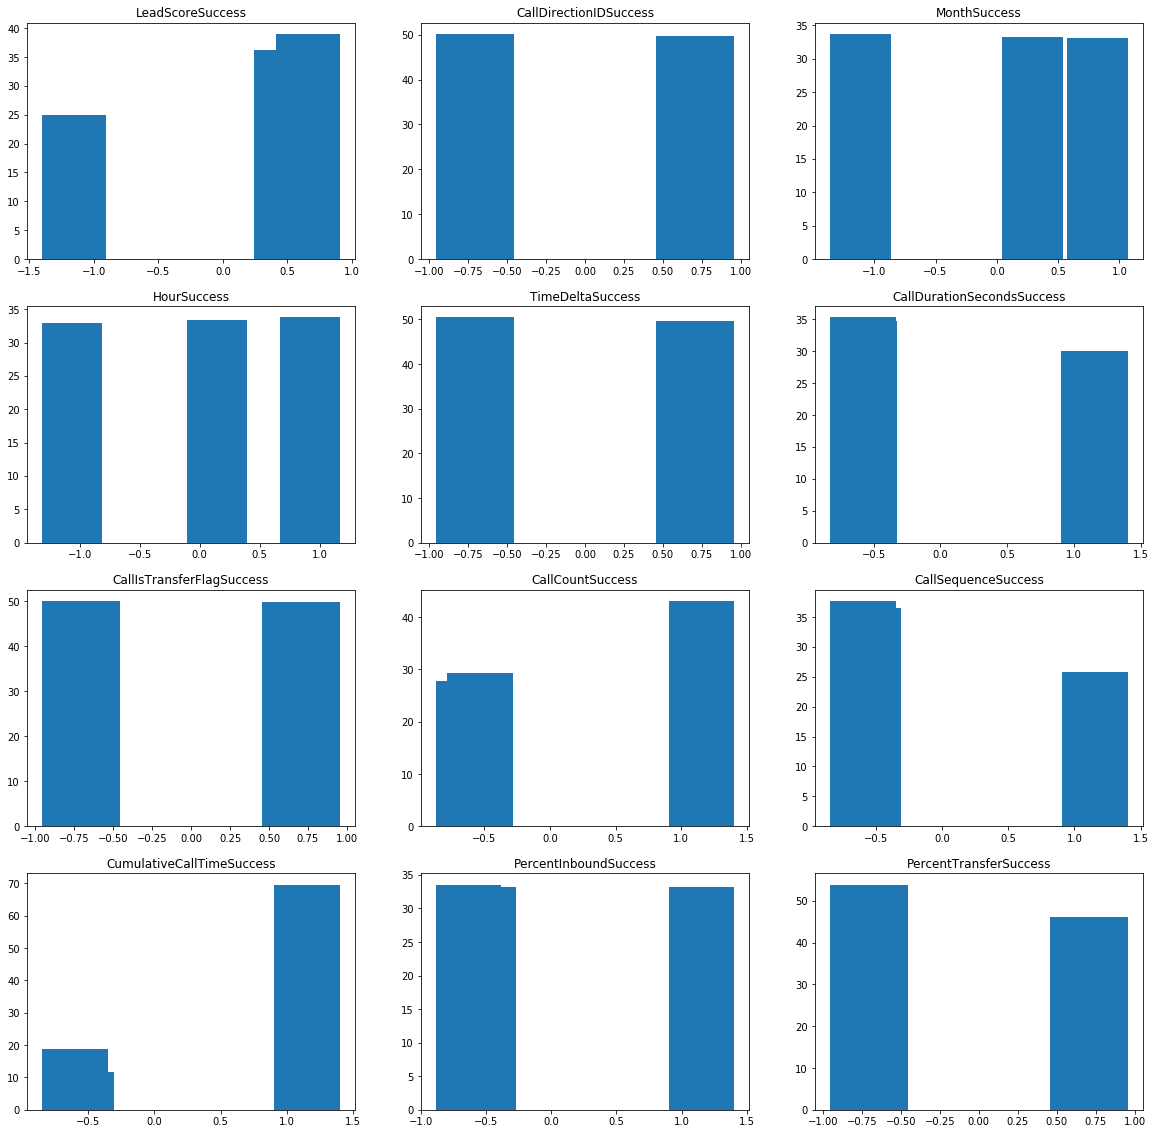

In [20]:
# get success dataframe
success=df[df['Success']==1]

# plot all the percent of variables that are successful
plt.figure(figsize=(20,20))
for i in range(12):
    plt.subplot(4,3,i+1)
    a=success.iloc[:,i].value_counts()
    plt.title(X.columns[i]+'Success')
    x=list(a.index)
    m=sum(x)/len(x)
    std=statistics.stdev(x)
    x=[(l-m)/std for l in x]
    y=list(a.values)
    y=[100*k/sum(y) for k in y]
    bar=plt.bar(x,y, width=0.5)
plt.savefig('allSuccess')

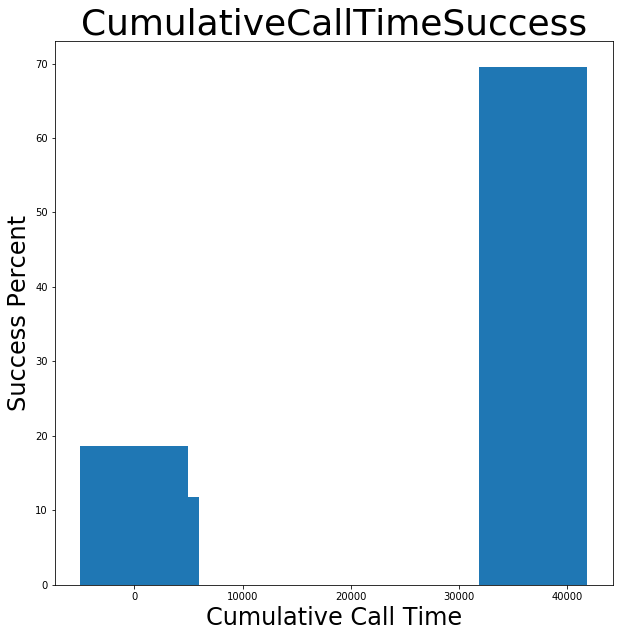

In [21]:
# plot cummulative call time success
plt.figure(figsize=(10,10))
plt.subplot(1,1,1)
a=success.iloc[:,9].value_counts()
plt.title(X.columns[9]+'Success', fontsize=36)
x=list(a.index)
y=list(a.values)
y=[100*k/sum(y) for k in y]
bar=plt.bar(x,y, width=10000)
plt.xlabel("Cumulative Call Time", fontsize=24)
plt.ylabel("Success Percent", fontsize=24)
plt.savefig('CallSuccess')

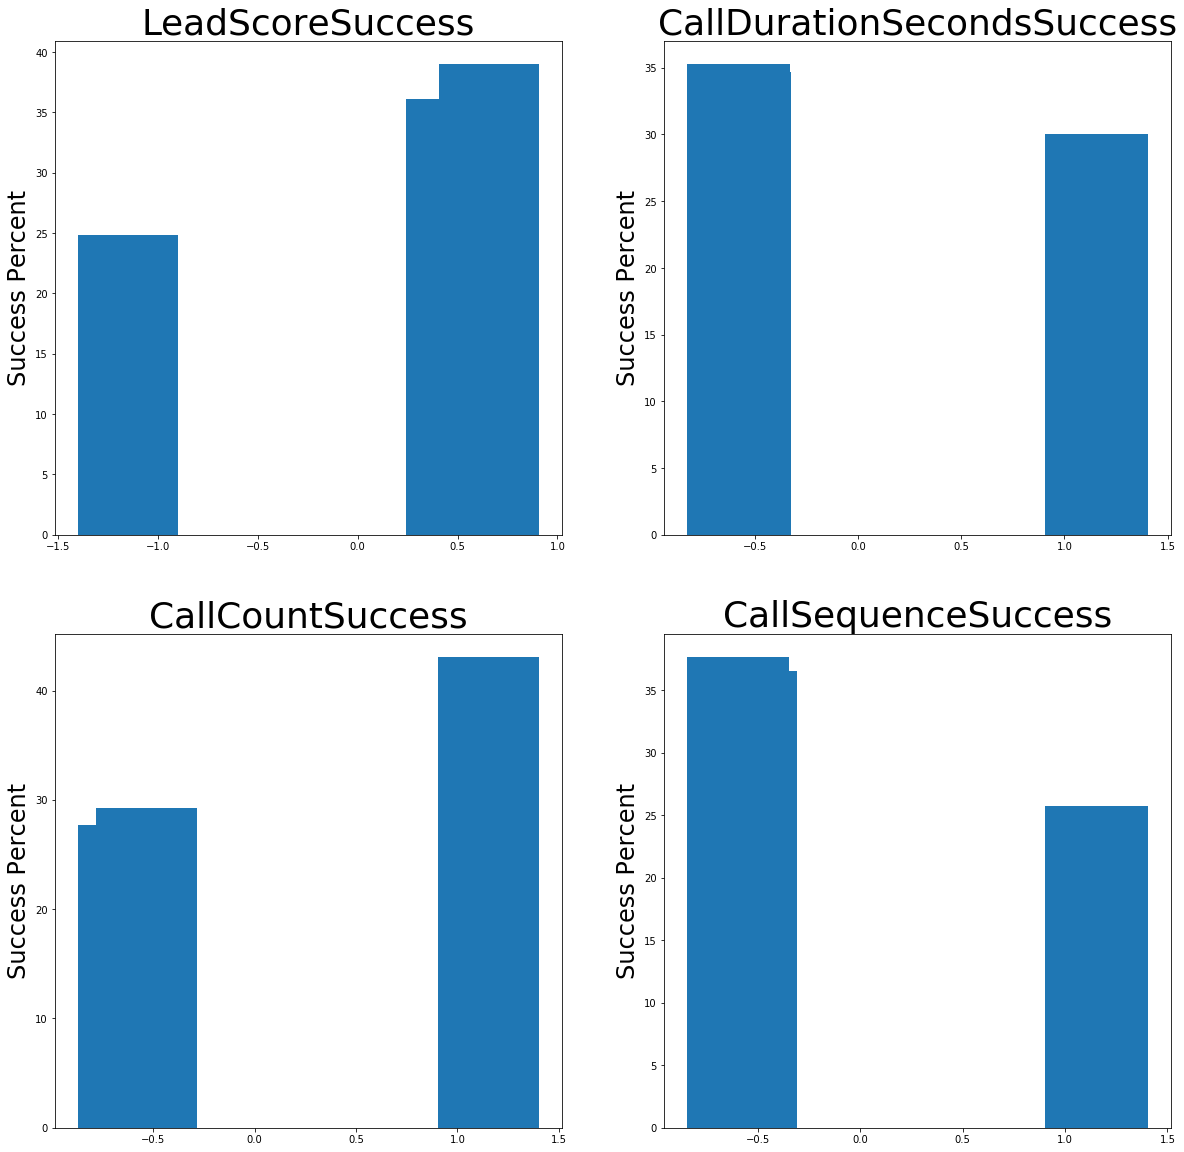

In [22]:
# plot next 4 variable that influence success
charts=[0,5,7,8]
plt.figure(figsize=(20,20))
for i in range (4):
    plt.subplot(2,2,i+1)
    a=success.iloc[:,charts[i]].value_counts()
    plt.title(X.columns[charts[i]]+'Success', fontsize=36)
    x=list(a.index)
    m=sum(x)/len(x)
    std=statistics.stdev(x)
    x=[(l-m)/std for l in x]
    y=list(a.values)
    y=[100*k/sum(y) for k in y]
    bar=plt.bar(x,y, width=0.5)
    plt.ylabel("Success Percent", fontsize=24)
plt.savefig('4Success')

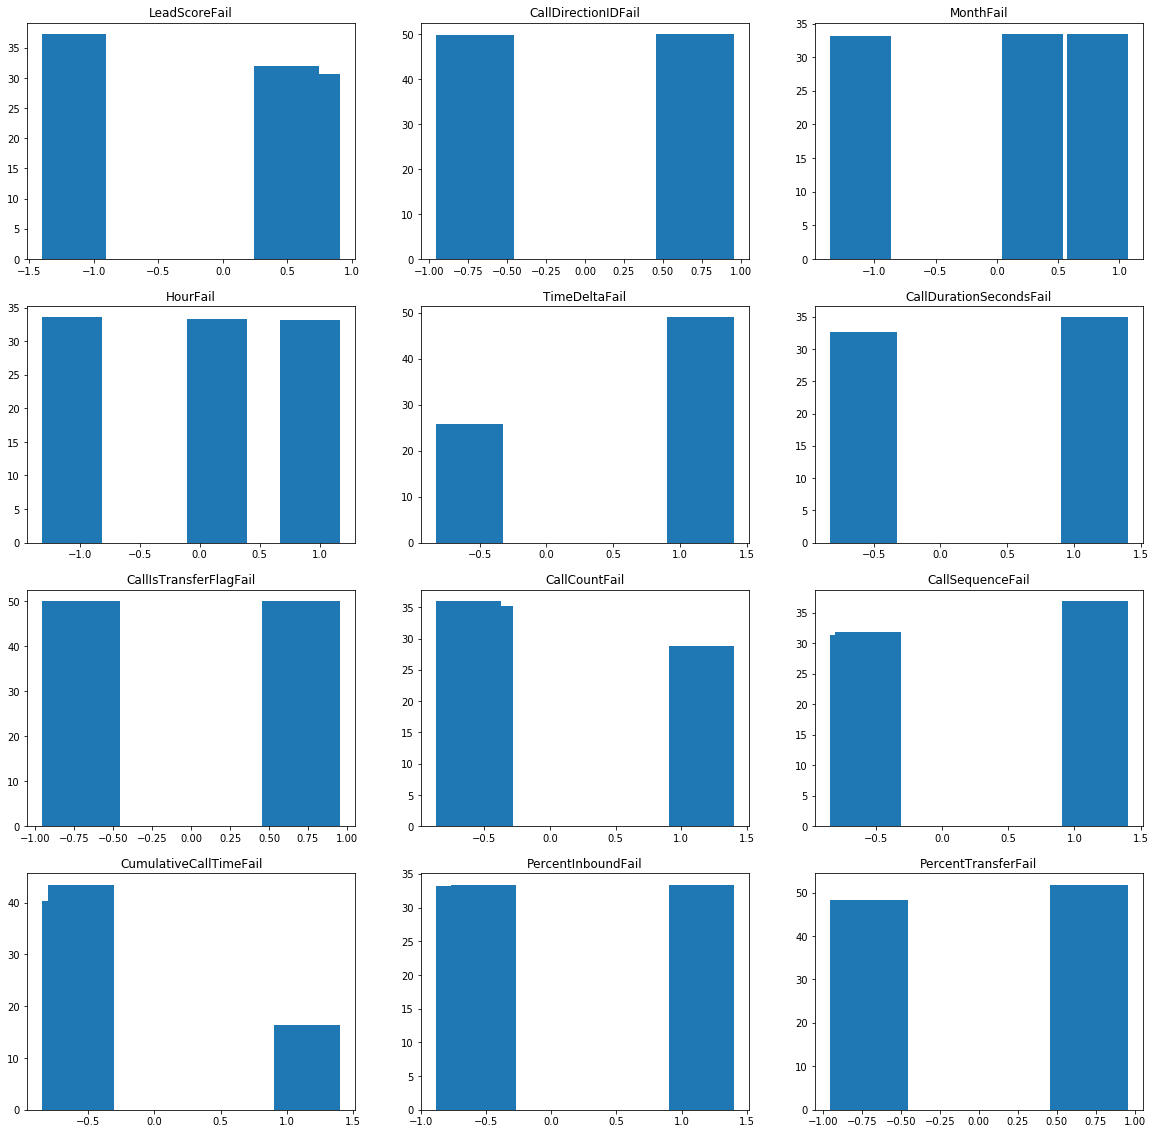

In [23]:
# create fail dataframe
fail=df[df['Success']==0]

# plot all the percent of variables that are fail
plt.figure(figsize=(20,20))
for i in range(12):
    plt.subplot(4,3,i+1)
    a=fail.iloc[:,i].value_counts()
    plt.title(X.columns[i]+'Fail')
    x=list(a.index)
    m=sum(x)/len(x)
    std=statistics.stdev(x)
    x=[(l-m)/std for l in x]
    y=list(a.values)
    y=[100*k/sum(y) for k in y]
    bar=plt.bar(x,y, width=0.5)
plt.savefig('allfail')

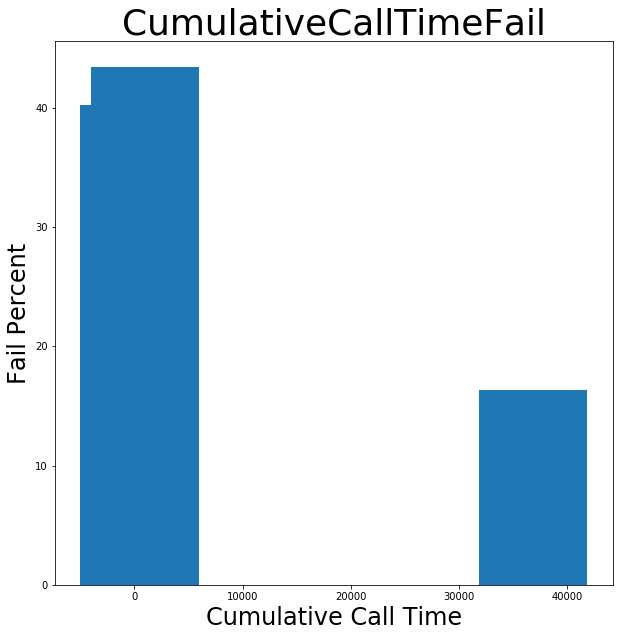

In [24]:
# plot the cumulative call time fail
plt.figure(figsize=(10,10))
plt.subplot(1,1,1)
a=fail.iloc[:,9].value_counts()
plt.title(X.columns[9]+'Fail', fontsize=36)
x=list(a.index)
y=list(a.values)
y=[100*k/sum(y) for k in y]
bar=plt.bar(x,y, width=10000)
plt.xlabel("Cumulative Call Time", fontsize=24)
plt.ylabel("Fail Percent", fontsize=24)
plt.savefig('CallFail')

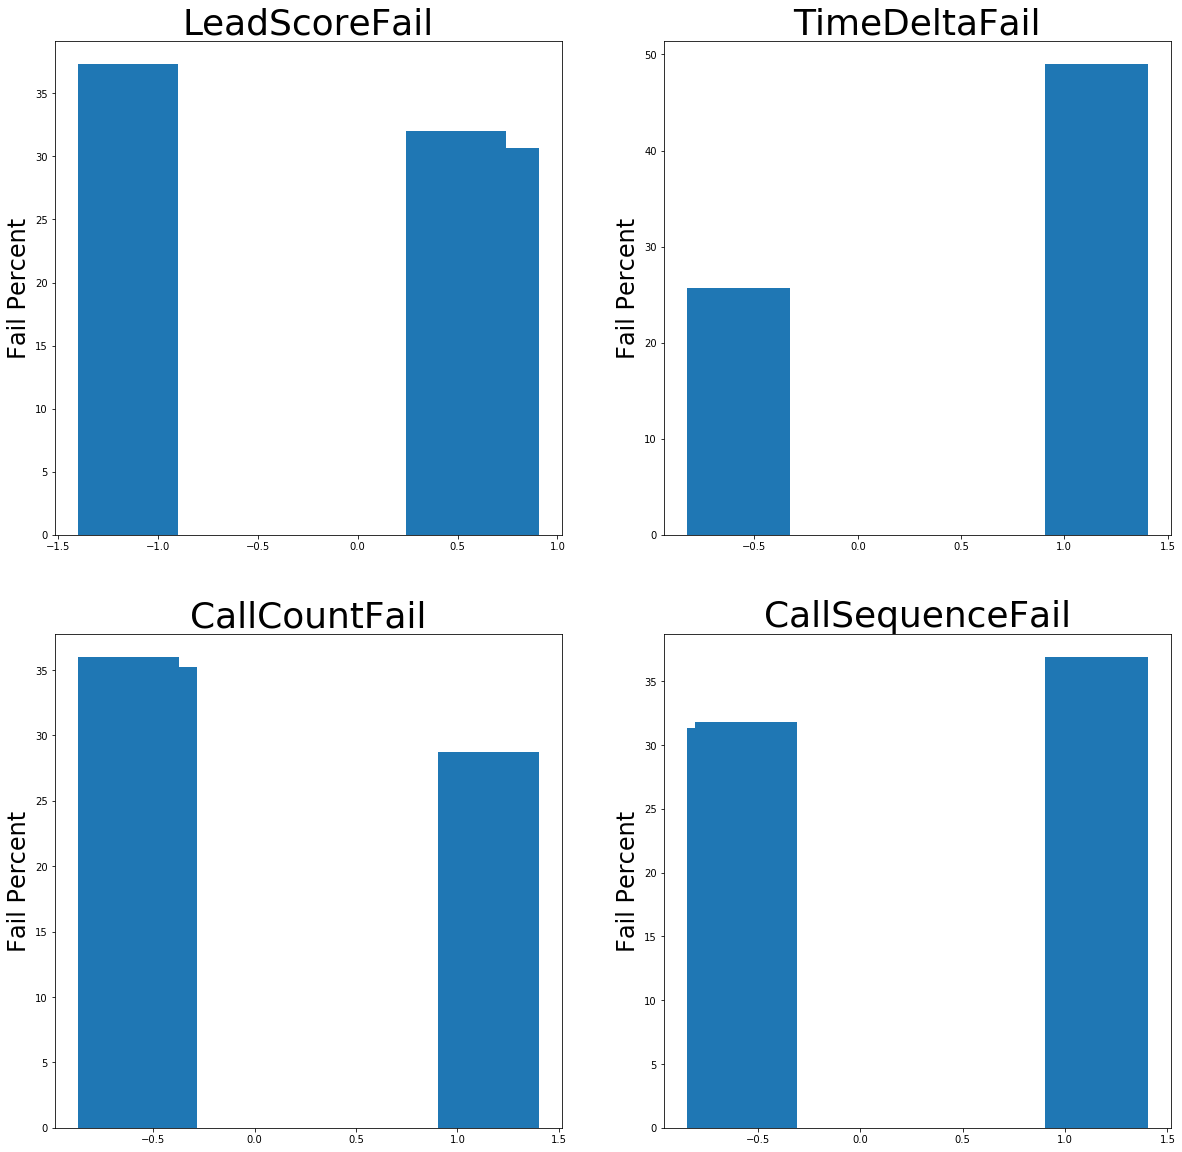

In [25]:
# plot next 4 variable that influence fail
charts=[0,4,7,8]
plt.figure(figsize=(20,20))
for i in range (4):
    plt.subplot(2,2,i+1)
    a=fail.iloc[:,charts[i]].value_counts()
    plt.title(X.columns[charts[i]]+'Fail', fontsize=36)
    x=list(a.index)
    m=sum(x)/len(x)
    std=statistics.stdev(x)
    x=[(l-m)/std for l in x]
    y=list(a.values)
    y=[100*k/sum(y) for k in y]
    bar=plt.bar(x,y, width=0.5)
    plt.ylabel("Fail Percent", fontsize=24)
plt.savefig('4Fail')